# [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

In this lecture, we will explore the architecture of DistilBERT, its key components, and how it can be utilized for various natural language processing tasks. Additionally, we'll discuss its advantages, limitations, and provide hands-on examples to showcase its effectiveness.

Reference : [The Theory](https://towardsdatascience.com/distillation-of-bert-like-models-the-code-73c31e8c2b0a) | [Code](https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f)

In [2]:
import os

In [3]:
# !pip install datasets --upgrade
import datasets
import transformers
import torch
datasets.__version__, transformers.__version__, torch.__version__

('2.17.1', '4.38.1', '2.0.1+cu117')

In [4]:
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


## 1. Loading our MNLI part of the GLUE dataset

In [5]:
import datasets

###1. Load Dataset
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}

task_name = "mnli"
raw_datasets = datasets.load_dataset("glue", task_name)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [6]:
label_list = raw_datasets['train'].features['label'].names
label2id = {v: i for i, v in enumerate(label_list)}
label2id

{'entailment': 0, 'neutral': 1, 'contradiction': 2}

In [7]:
id2label = {i: v for v, i in label2id.items()}
id2label

{0: 'entailment', 1: 'neutral', 2: 'contradiction'}

## 2. Model & Tokenization

In [8]:
import numpy as np 
num_labels = np.unique(raw_datasets['train']['label']).size
num_labels

3

In [9]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

teacher_id = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(teacher_id)

teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_id, 
    num_labels = num_labels,
    id2label = id2label,
    label2id = label2id,
)

teacher_model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 3. Preprocessing 

In [10]:
def tokenize_function(examples):
    sentence1_key, sentence2_key = task_to_keys[task_name]
    args = (
        (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
    )
    result = tokenizer(*args, max_length=128, truncation=True)
    return result

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:  10%|█         | 1000/9815 [00:00<00:01, 5860.20 examples/s]

Map: 100%|██████████| 9815/9815 [00:01<00:00, 8478.42 examples/s]


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [12]:
# list(task_to_keys[task_name])
column_dataset = [item for item in task_to_keys[task_name] if item is not None]
column_dataset

['premise', 'hypothesis']

In [13]:
#remove column : 'premise', 'hypothesis', 'idx'
tokenized_datasets = tokenized_datasets.remove_columns(column_dataset + ["idx"])
#rename column : 'labels'
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

In [14]:
tokenized_datasets['train'][0]['input_ids']

tensor([  101, 17158,  2135,  6949,  8301, 25057,  2038,  2048,  3937,  9646,
         1011,  4031,  1998, 10505,  1012,   102,  4031,  1998, 10505,  2024,
         2054,  2191,  6949,  8301, 25057,  2147,  1012,   102])

In [15]:
tokenizer.decode(tokenized_datasets['train'][0]['input_ids'])

'[CLS] conceptually cream skimming has two basic dimensions - product and geography. [SEP] product and geography are what make cream skimming work. [SEP]'

## 4. Preparing the dataloader

In [16]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
#Data collator that will dynamically pad the inputs received.

In [17]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=1150).select(range(10000))
small_eval_dataset = tokenized_datasets["validation_mismatched"].shuffle(seed=1150).select(range(1000))
small_test_dataset = tokenized_datasets["test_mismatched"].shuffle(seed=1150).select(range(1000))

In [18]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(
    small_train_dataset, shuffle=True, batch_size=32, collate_fn=data_collator)
test_dataloader = DataLoader(
    small_test_dataset, batch_size=32, collate_fn=data_collator)
eval_dataloader = DataLoader(
    small_eval_dataset, batch_size=32, collate_fn=data_collator)

In [19]:
for batch in train_dataloader:
    break
    
batch['labels'].shape, batch['input_ids'].shape, batch['attention_mask'].shape

(torch.Size([32]), torch.Size([32, 121]), torch.Size([32, 121]))

## 5. Design the model and losses

### 5.1 Teacher Model & Student Model

####  Architecture 
In the present work, the student - DistilBERT - has the same general architecture as BERT. 
- The `token-type embeddings` and the `pooler` are removed while `the number of layers` is reduced by a factor of 2. 
- Most of the operations used in the Transformer architecture `linear layer` and `layer normalisation` are highly optimized in modern linear algebra frameworks.
- our investigations showed that variations on the last dimension of the tensor (hidden size dimension) have a smaller impact on computation efficiency (for a fixed parameters budget) than variations on other factors like the number of layers. 
- Thus we focus on reducing the number of layers.

#### Initialize Student Model
- To initialize a new model from an existing one, we need to access the weights of the old model (the teacher). 
- In order to get the weights, we first have to know how to access them. We’ll use BERT as our teacher model.

In [20]:
teacher_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "entailment",
    "1": "neutral",
    "2": "contradiction"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "contradiction": 2,
    "entailment": 0,
    "neutral": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

#### 
- The student model has the same configuration, except the number of layers is reduced by a factor of 2
- The student layers are initilized by copying one out of two layers of the teacher, starting with layer 0.
- The head of the teacher is also copied.

In [21]:
from transformers.models.bert.modeling_bert import BertPreTrainedModel, BertConfig
# Get teacher configuration as a dictionnary
configuration = teacher_model.config.to_dict()
# configuration

In [22]:
# Half the number of hidden layer
configuration['num_hidden_layers'] //= 2
# Convert the dictionnary to the student configuration
configuration = BertConfig.from_dict(configuration)

In [23]:
# Create uninitialized student model
model = type(teacher_model)(configuration)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

- Recursively copies the weights of the (teacher) to the (student).
- This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
- The only part that's not fully copied is the encoder, of which only half is copied.

In [24]:
from transformers.models.bert.modeling_bert import BertEncoder, BertModel
from torch.nn import Module

def distill_bert_weights(
    teacher : Module,
    student : Module,
    init_method = 'top'
) -> None:
    """
    Recursively copies the weights of the (teacher) to the (student).
    This function is meant to be first called on a BertFor... model, but is then called on every children of that model recursively.
    The only part that's not fully copied is the encoder, of which only half is copied.
    """
    # If the part is an entire BERT model or a BERTFor..., unpack and iterate
    if isinstance(teacher, BertModel) or type(teacher).__name__.startswith('BertFor'):
        for teacher_part, student_part in zip(teacher.children(), student.children()):
            distill_bert_weights(teacher_part, student_part)
    # Else if the part is an encoder, copy one out of every layer
    elif isinstance(teacher, BertEncoder):
        teacher_encoding_layers = [layer for layer in next(teacher.children())] #12 layers
        student_encoding_layers = [layer for layer in next(student.children())] #6 layers

        if init_method == 'top':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i].state_dict())

        elif init_method == 'bottom':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i+len(student_encoding_layers)].state_dict())

        elif init_method == 'odd':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2-1].state_dict())

        elif init_method == 'even':
            for i in range(len(student_encoding_layers)):
                student_encoding_layers[i].load_state_dict(teacher_encoding_layers[i*2].state_dict())

        else:
            raise Exception("init_method is invalid. Select between 'top', 'bottom', 'odd', 'even'")

    # Else the part is a head or something else, copy the state_dict
    else:
        student.load_state_dict(teacher.state_dict())

    return model

In [25]:
models = {'Top-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='top'),
          'Bottom-K Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='bottom'),
          'Odd Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='odd'),
          'Even Layer': distill_bert_weights(teacher=teacher_model, student=model, init_method='even')}

In [26]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Teacher parameters :', count_parameters(teacher_model))
for model_name, model in models.items():
    print(f'Student ({model_name}) parameters :', count_parameters(model))

Teacher parameters : 109484547
Student (Top-K Layer) parameters : 66957315
Student (Bottom-K Layer) parameters : 66957315
Student (Odd Layer) parameters : 66957315
Student (Even Layer) parameters : 66957315


All student models have the same no. of parameters

In [27]:
count_parameters(models['Top-K Layer'])/count_parameters(teacher_model) * 100

61.15686353435797

In [28]:
#It has 40% less parameters than bert-base-uncased

### 5.2 Loss function

#### Softmax

$$
P_i(\mathbf{z}_i, T) = \frac{\exp(\mathbf{z}_i / T)}{\sum_{q=0}^k \exp(\mathbf{z}_q / T)}
$$


#### Knowledge Distillation

#### CE Loss
$$\mathcal{L}_\text{CE} = -\sum^N_{j=0}\sum_{i=0}^k {y}_i^{(j)}\log(P_i({v}_i^{(j)}, 1))$$

#### KL Loss
$$\mathcal{L}_\text{KD} = -\sum^N_{j=0}\sum_{i=0}^k P_i({z}_i^{(j)}, T) \log (P_i({v}_i^{(j)}, T))$$

#### Cosine Embedding Loss
$$\mathcal{L}_{\text{cosine}}(x_1, x_2, y) = \frac{1}{N} \sum_{i=1}^{N} \left(1 - y_i \cdot \cos(\theta_i)\right)$$

<!-- $$\mathcal{L} = \lambda \mathcal{L}_\text{KD} + (1-\lambda)\mathcal{L}_\text{CE}$$
 -->

#### Total Loss
$$\mathcal{L} = \mathcal{L}_\text{KD} + \mathcal{L}_\text{CE} + \mathcal{L}_{\text{cosine}}$$

In [29]:
import torch.nn.functional as F

class DistillKL(nn.Module):
    """
    Distilling the Knowledge in a Neural Network
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha

    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! 
    """

    def __init__(self):
        super(DistillKL, self).__init__()

    def forward(self, output_student, output_teacher, temperature=1):
        '''
        Note: the output_student and output_teacher are logits 
        '''
        T = temperature #.cuda()
        
        KD_loss = nn.KLDivLoss(reduction='batchmean')(
            F.log_softmax(output_student/T, dim=-1),
            F.softmax(output_teacher/T, dim=-1)
        ) * T * T
        
        return KD_loss

In [30]:
criterion_div = DistillKL()
criterion_cos = nn.CosineEmbeddingLoss()

## 6. Optimizer

In [31]:
import torch.optim as optim
import torch.nn as nn

lr = 5e-5

#training hyperparameters
optimizer = optim.Adam(params=model.parameters(), lr=lr)

In [32]:
model = model.to(device)
teacher_model = teacher_model.to(device)

## 7. Learning rate scheduler

In [33]:
from transformers import get_scheduler

num_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

## 8. Metric

In [34]:
# !pip3 install evaluate

In [35]:
import numpy as np
import evaluate
# Get the metric function
if task_name is not None:
    metric = evaluate.load("glue", task_name)
else:
    metric = evaluate.load("accuracy")

## 9. Train

In [36]:
import torch
from tqdm.auto import tqdm

model_scores = {}

for model_name, model in models.items():

    print(f"\n===== {model_name} =====")

    progress_bar = tqdm(range(num_training_steps))
    eval_metrics = 0

    # Lists to store losses for each epoch
    train_losses = []
    train_losses_cls = []
    train_losses_div = []
    train_losses_cos = []
    eval_losses = []
    eval_accuracies = []  # Added list for storing evaluation accuracies

    for epoch in range(num_epochs):
        model.train()
        teacher_model.eval()
        train_loss = 0
        train_loss_cls = 0
        train_loss_div = 0
        train_loss_cos = 0
        
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            # compute student output
            outputs = model(**batch) 
            # compute teacher output
            with torch.no_grad():
                output_teacher = teacher_model(**batch)

            # assert size
            assert outputs.logits.size() == output_teacher.logits.size()
            
            # cls loss 
            loss_cls  = outputs.loss
            train_loss_cls += loss_cls.item()
            # distillation loss
            loss_div = criterion_div(outputs.logits, output_teacher.logits)
            train_loss_div += loss_div.item()
            # cosine loss
            loss_cos = criterion_cos(output_teacher.logits, outputs.logits, torch.ones(output_teacher.logits.size()[0]).to(device))
            train_loss_cos += loss_cos.item()
            
            # Average the loss and return it
            loss = (loss_cls + loss_div + loss_cos) / 3
            
            train_loss += loss.item()
            loss.backward()
            # accelerator.backward(loss)
            # Step with optimizer
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            
        train_losses.append(train_loss / len(train_dataloader))
        train_losses_cls.append(train_loss_cls / len(train_dataloader))
        train_losses_div.append(train_loss_div / len(train_dataloader))
        train_losses_cos.append(train_loss_cos / len(train_dataloader))

        print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
        print(f'  - Loss_cls: {train_loss_cls/len(train_dataloader):.4f}')
        print(f'  - Loss_div: {train_loss_div/len(train_dataloader):.4f}')
        print(f'  - Loss_cos: {train_loss_cos/len(train_dataloader):.4f}')
        
        model.eval()
        eval_loss = 0
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                
            loss_cls = outputs.loss
            predictions = outputs.logits.argmax(dim=-1)

            eval_loss += loss_cls.item()
            metric.add_batch(
                predictions=predictions, 
                references=batch["labels"])
            
        eval_metric = metric.compute()
        eval_metrics += eval_metric['accuracy'] 
        eval_losses.append(eval_loss / len(eval_dataloader))  # Save the evaluation loss for plotting
        eval_accuracies.append(eval_metric['accuracy'])  # Save the evaluation accuracy

        print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
        
    print('Avg Metric', eval_metrics/num_epochs)

    model_scores[model_name] = {
        'train_losses': train_losses,
        'train_losses_cls': train_losses_cls,
        'train_losses_div': train_losses_div,
        'train_losses_cos': train_losses_cos,
        'eval_losses': eval_losses,
        'eval_accuracies': eval_accuracies  # Include evaluation accuracies in the dictionary
    }
    
    progress_bar.reset()



===== Top-K Layer =====


 33%|███▎      | 313/939 [01:36<02:31,  4.14it/s]

Epoch at 1: Train loss 0.3511:
  - Loss_cls: 0.9531
  - Loss_div: 0.0511
  - Loss_cos: 0.0491


 33%|███▎      | 314/939 [01:38<09:01,  1.15it/s]

Epoch at 1: Test Acc 0.6500


 67%|██████▋   | 626/939 [03:06<01:13,  4.29it/s]

Epoch at 2: Train loss 0.3046:
  - Loss_cls: 0.7519
  - Loss_div: 0.1135
  - Loss_cos: 0.0484
Epoch at 2: Test Acc 0.6740


100%|██████████| 939/939 [04:38<00:00,  3.95it/s]

Epoch at 3: Train loss 0.2747:
  - Loss_cls: 0.6195
  - Loss_div: 0.1550
  - Loss_cos: 0.0494


  0%|          | 0/939 [00:00<?, ?it/s]          

Epoch at 3: Test Acc 0.6650
Avg Metric 0.663

===== Bottom-K Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]


Epoch at 1: Train loss 0.2650:
  - Loss_cls: 0.5809
  - Loss_div: 0.1646
  - Loss_cos: 0.0495
Epoch at 1: Test Acc 0.6650


Epoch at 2: Train loss 0.2658:
  - Loss_cls: 0.5833
  - Loss_div: 0.1645
  - Loss_cos: 0.0496


Epoch at 2: Test Acc 0.6650


 67%|██████▋   | 627/939 [02:58<04:24,  1.18it/s]

Epoch at 3: Train loss 0.2653:
  - Loss_cls: 0.5817
  - Loss_div: 0.1648
  - Loss_cos: 0.0495


Epoch at 3: Test Acc 0.6650
Avg Metric 0.665

===== Odd Layer =====


 33%|███▎      | 312/939 [01:25<03:16,  3.19it/s]

Epoch at 1: Train loss 0.2652:
  - Loss_cls: 0.5806
  - Loss_div: 0.1653
  - Loss_cos: 0.0498


 33%|███▎      | 314/939 [01:28<07:05,  1.47it/s]

Epoch at 1: Test Acc 0.6650


 67%|██████▋   | 626/939 [02:54<01:11,  4.35it/s]

Epoch at 2: Train loss 0.2650:
  - Loss_cls: 0.5806
  - Loss_div: 0.1648
  - Loss_cos: 0.0497
Epoch at 2: Test Acc 0.6650


100%|██████████| 939/939 [04:26<00:00,  3.06it/s]

Epoch at 3: Train loss 0.2657:
  - Loss_cls: 0.5813
  - Loss_div: 0.1658
  - Loss_cos: 0.0500


  0%|          | 0/939 [00:00<?, ?it/s]          

Epoch at 3: Test Acc 0.6650
Avg Metric 0.665

===== Even Layer =====


  0%|          | 0/939 [00:00<?, ?it/s]


Epoch at 1: Train loss 0.2651:
  - Loss_cls: 0.5794
  - Loss_div: 0.1660
  - Loss_cos: 0.0500
Epoch at 1: Test Acc 0.6650


Epoch at 2: Train loss 0.2652:
  - Loss_cls: 0.5796
  - Loss_div: 0.1663
  - Loss_cos: 0.0498
Epoch at 2: Test Acc 0.6650


Epoch at 3: Train loss 0.2655:
  - Loss_cls: 0.5820
  - Loss_div: 0.1648
  - Loss_cos: 0.0498


Epoch at 3: Test Acc 0.6650
Avg Metric 0.665


In [40]:
for model_name, scores in model_scores.items():
    print(f"\nModel: {model_name}")
    print(f"Train Loss: {scores['train_losses'][-1]:.4f}")
    print(f"Eval Loss: {scores['eval_losses'][-1]:.4f}")
    print(f"Eval Accuracy: {scores['eval_accuracies'][-1]:.4f}")



Model: Top-K Layer
Train Loss: 0.2747
Eval Loss: 0.8079
Eval Accuracy: 0.6650

Model: Bottom-K Layer
Train Loss: 0.2653
Eval Loss: 0.8079
Eval Accuracy: 0.6650

Model: Odd Layer
Train Loss: 0.2657
Eval Loss: 0.8079
Eval Accuracy: 0.6650

Model: Even Layer
Train Loss: 0.2655
Eval Loss: 0.8079
Eval Accuracy: 0.6650


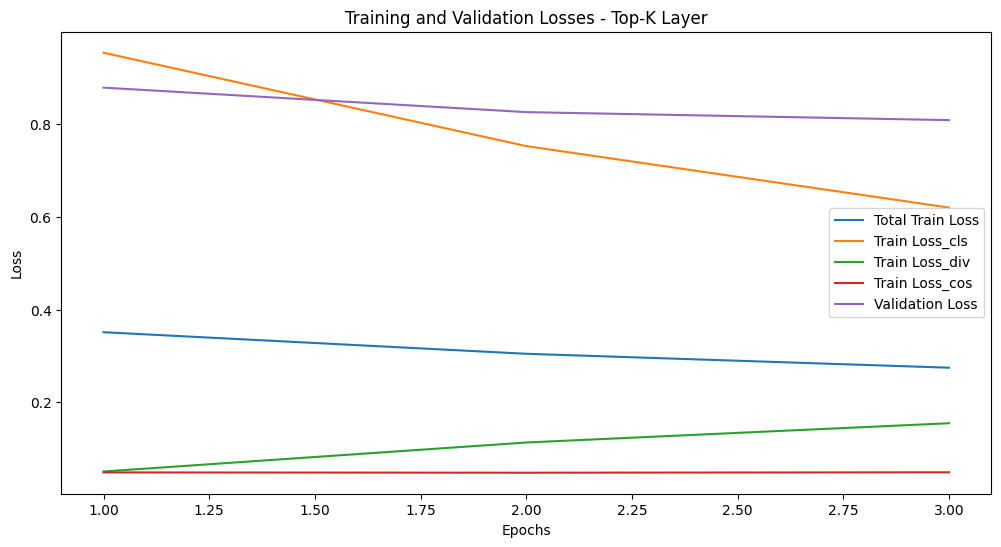

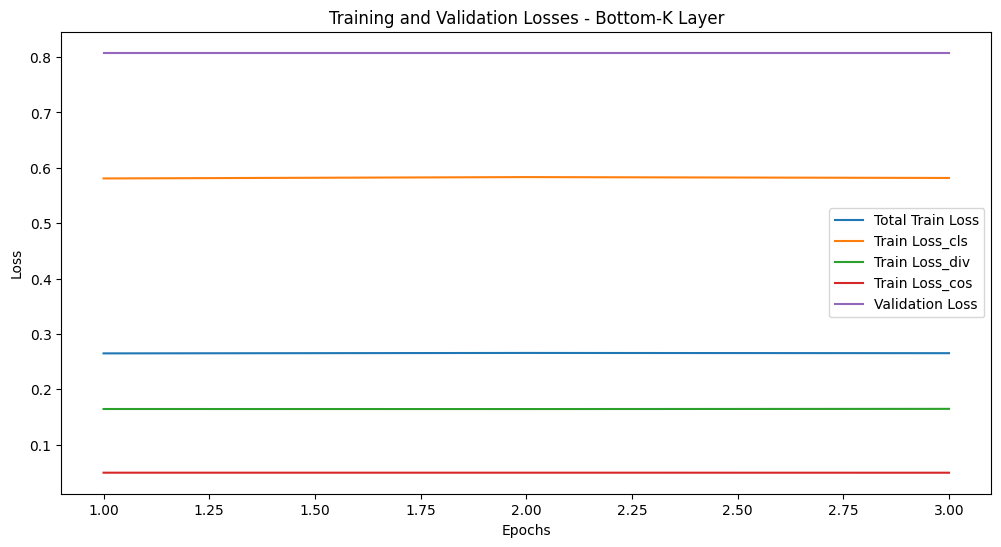

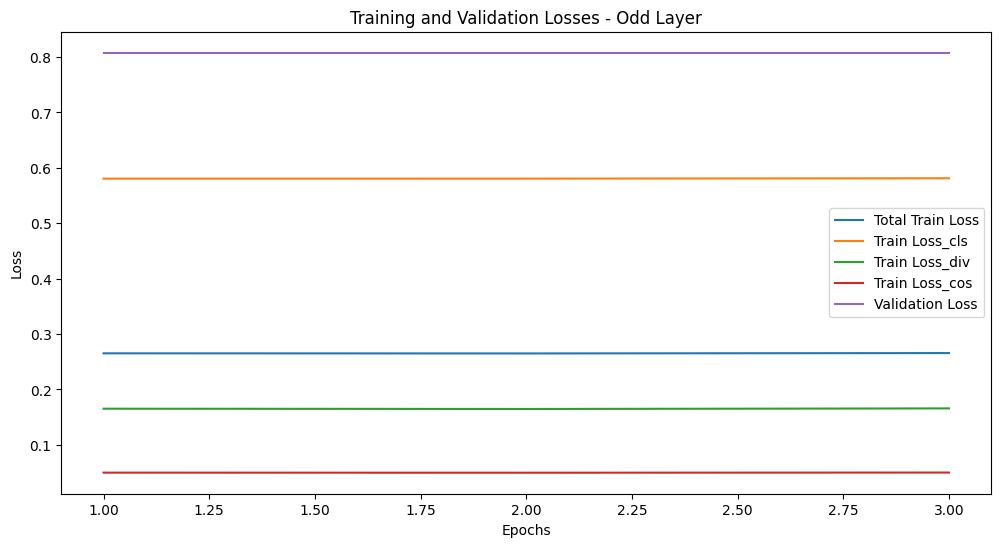

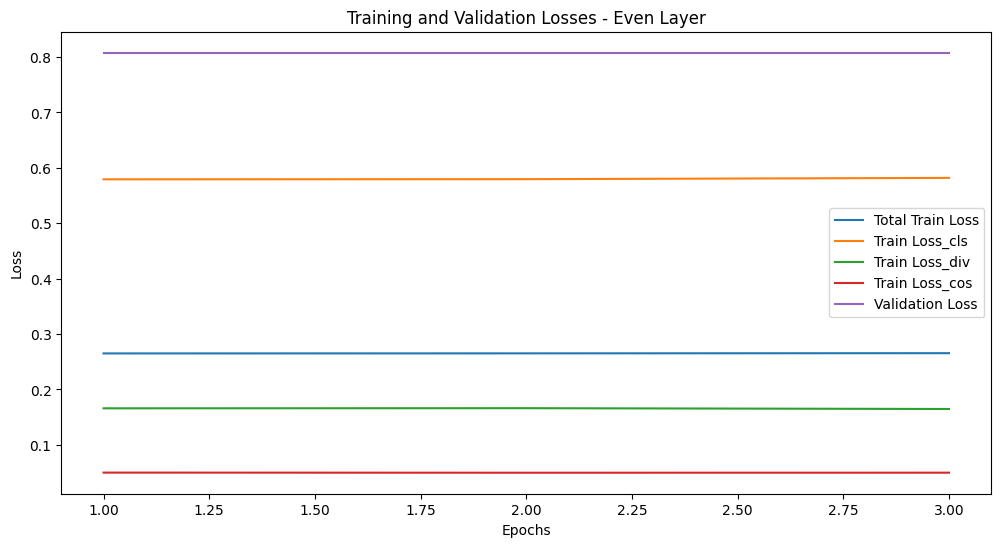

In [38]:
import matplotlib.pyplot as plt

# Assuming you have a list of model names
model_names = list(model_scores.keys())

# Plotting separately for each model
for model_name in model_names:
    scores = model_scores[model_name]

    # Extracting loss lists
    train_losses = scores['train_losses']
    train_losses_cls = scores['train_losses_cls']
    train_losses_div = scores['train_losses_div']
    train_losses_cos = scores['train_losses_cos']
    eval_losses = scores['eval_losses']

    # Plotting
    epochs_list = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(epochs_list, train_losses, label='Total Train Loss')
    plt.plot(epochs_list, train_losses_cls, label='Train Loss_cls')
    plt.plot(epochs_list, train_losses_div, label='Train Loss_div')
    plt.plot(epochs_list, train_losses_cos, label='Train Loss_cos')
    plt.plot(epochs_list, eval_losses, label='Validation Loss')

    plt.title(f'Training and Validation Losses - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Appendix (Teacher Model)

In [39]:
# import torch
# from tqdm.auto import tqdm
# import torch.optim as optim
# import torch.nn as nn

# lr = 5e-5
# #training hyperparameters
# optimizer = optim.Adam(params=teacher_model.parameters(), lr=lr)

# progress_bar = tqdm(range(num_training_steps))
# eval_metrics = 0

# for epoch in range(num_epochs):
#     teacher_model.train()
#     train_loss = 0
#     for step, batch in enumerate(train_dataloader):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         output_teacher = teacher_model(**batch)
#         # cls loss 
#         loss = output_teacher.loss
#         train_loss += loss.item()
#         loss.backward()
#         # accelerator.backward(loss)
#         # Step with optimizer
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

#     print(f'Epoch at {epoch+1}: Train loss {train_loss/len(train_dataloader):.4f}:')
    
#     teacher_model.eval()
#     for step, batch in enumerate(eval_dataloader):
#         batch = {k: v.to(device) for k, v in batch.items()}
#         with torch.no_grad():
#             outputs = teacher_model(**batch)
    
#         predictions = outputs.logits.argmax(dim=-1)
#         # predictions, references = accelerator.gather((predictions, batch["labels"]))
#         metric.add_batch(
#             predictions=predictions, 
#             references=batch["labels"])
        
#     eval_metric = metric.compute()
#     eval_metrics += eval_metric['accuracy'] 
#     print(f"Epoch at {epoch+1}: Test Acc {eval_metric['accuracy']:.4f}")
    
# print('Avg Metric', eval_metrics/num_epochs)

# Documentation

## Perform a detailed evaluation of your distilled student model, analyzing the impact of the initial
 layer selection (top K layers, bottom K layers, odd layers) on its performance.


|Student Layer         | Training Loss | Validation Loss | Validation Accuracy |
|---------------|---------------|------------------|----------------------|
| Top-K  Layer | 0.274         | 0.808            | 0.665                 |
| Bottom-K Layer| 0.265        | 0.808              | 0.665                  |
| Odd Layer     | 0.266           | 0.808          | 0.665                  |
| Even Layer    | 0.266           | 0.808              | 0.665                  |

Training Loss: The training loss is consistent across the different layer selection strategies, indicating that the models converge similarly during the training process.

Validation Loss: The validation loss values are identical for all layer selection methods, suggesting that the selected layers have similar generalization capabilities on the validation set.

Validation Accuracy: The validation accuracy is also consistent, reinforcing the idea that the initial layer selection strategy does not significantly affect the model's ability to make accurate predictions on unseen data.

Based on these results, it seems that the choice of initial layer selection does not lead to noticeable differences in the performance metrics of your distilled student model. This finding could be beneficial as it implies that the model is robust to variations in the initial layer selection strategy.

## Discuss any limitations or challenges encountered during the implementation of student distillation, specifically focusing on the analysis of how the initial layer selection affects the overall performance. Propose potential improvements or modifications to address these challenges.

### Limitations and Challenges:

Layer Importance Dynamics: The approach assumes that the importance of layers is fixed, and the selected layers from the teacher model are directly transferred to the student. However, the importance of layers may vary during the training process, leading to suboptimal knowledge transfer.

Model Sensitivity: The model might be sensitive to the choice of layers initially selected, especially if the selected layers do not capture crucial features for the given task. This sensitivity can result in similar performance across different layer selections.

Overfitting to Specific Layers: Depending on the dataset and task, the model might overfit to specific layers selected during distillation. This overfitting could limit the model's ability to generalize to diverse inputs.

Lack of Dynamic Adaptation: The initial layer selection is static throughout the training process, which may not adapt well to changes in the model's learning dynamics. The model might benefit from dynamically adjusting the selected layers during training.

### Potential Improvements:

Dynamic Layer Selection: Implement a mechanism for dynamically adjusting the selected layers during training. This could involve monitoring the performance of different layers and adapting the selection strategy based on the model's learning progress.

Fine-Tuning Selected Layers: Allow for fine-tuning of the selected layers during the training process. This enables the model to refine its representation based on the task-specific information present in the dataset.

Ensemble Learning: Train multiple student models with different layer selections and create an ensemble. This approach helps mitigate the risk of overfitting to specific layers and improves overall model robustness.

Attention Mechanisms: Integrate attention mechanisms into the distillation process. This allows the model to dynamically focus on informative parts of the teacher's representation, enhancing the knowledge transfer process.

Regularization Techniques: Apply regularization techniques to prevent overfitting to specific layers. Techniques such as dropout or layer-wise regularization can promote more diverse learning across layers.

By addressing these potential improvements, you can enhance the flexibility and adaptability of the student distillation process, potentially leading to improved performance across various layer selection strategies. Experimenting with these modifications and monitoring their impact on the model's generalization would provide valuable insights into optimizing the distillation process.